In [ ]:
# the following notebook is mostly based on https://keras.io/guides/transfer_learning/

In [1]:
%matplotlib inline

from IPython.display import display as d
from IPython.display import Image 

import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("white")
import glob
import json
import os
import sys
import json
import shutil
import os
import sys
import multiprocessing
import shutil
from pprint import pprint

pool = multiprocessing.Pool(multiprocessing.cpu_count())

In [ ]:
#!pip3 install keras tensorflow

In [2]:
import tensorflow as tf
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
directory = "data/rule_of_thirds/"
batch_size = 32

def read_images(directory, subset, batch_size=32):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory, 
        labels='inferred', 
        label_mode='int',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=(299, 299), 
        shuffle=True, 
        seed=42, 
        validation_split=0.1,  # 10% validation 
        subset=subset,
        interpolation='bilinear'
    )

training = read_images(directory, "training", batch_size)
print(training)

validation = read_images(directory, "validation", batch_size)
print(validation)

Found 3646 files belonging to 2 classes.
Using 3282 files for training.
<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>
Found 3646 files belonging to 2 classes.
Using 364 files for validation.
<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>


In [4]:
import matplotlib.pyplot as plt

def overview_dataset(data):
    class_names = data.class_names

    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
          for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[labels[i]])
                plt.axis("off")



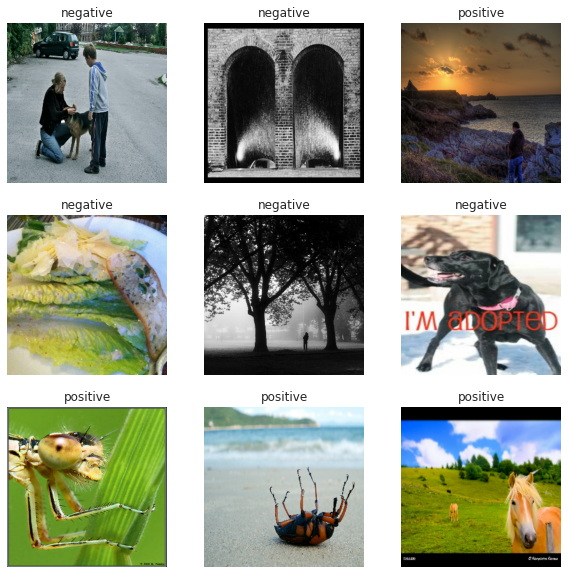

In [5]:
overview_dataset(training)

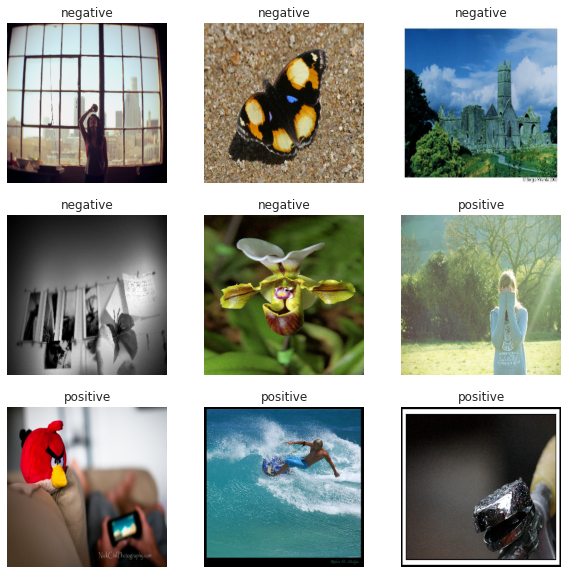

In [6]:
overview_dataset(validation)

In [7]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# we cant do data_augmentation
# x = data_augmentation(inputs)  # Apply random data augmentation
x = inputs
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 299, 299, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable params: 20,861,487
_____________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(training, epochs=epochs, validation_data=validation)

Epoch 1/20
103/103 [==============================] - 100s 893ms/step - loss: 0.6651 - binary_accuracy: 0.5545 - val_loss: 0.6171 - val_binary_accuracy: 0.5769
Epoch 2/20
103/103 [==============================] - 89s 819ms/step - loss: 0.5974 - binary_accuracy: 0.6230 - val_loss: 0.5923 - val_binary_accuracy: 0.6154
Epoch 3/20
103/103 [==============================] - 90s 826ms/step - loss: 0.5625 - binary_accuracy: 0.6788 - val_loss: 0.5780 - val_binary_accuracy: 0.6401
Epoch 4/20
103/103 [==============================] - 90s 821ms/step - loss: 0.5398 - binary_accuracy: 0.7034 - val_loss: 0.5706 - val_binary_accuracy: 0.6731
Epoch 5/20
103/103 [==============================] - 90s 824ms/step - loss: 0.5302 - binary_accuracy: 0.7124 - val_loss: 0.5662 - val_binary_accuracy: 0.6676
Epoch 6/20
103/103 [==============================] - 90s 822ms/step - loss: 0.5192 - binary_accuracy: 0.7294 - val_loss: 0.5615 - val_binary_accuracy: 0.6896
Epoch 7/20
103/103 [=========================

In [ ]:

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(training, epochs=epochs, validation_data=validation)